In [2]:
import os
from tqdm import tqdm
import cv2
import multiprocessing
from metadata import Metadata
import matplotlib.pyplot as plt
from dredFISH.Processing.Section import *
import numpy as np
import torch
from scipy.ndimage import gaussian_filter,percentile_filter,median_filter,minimum_filter
dataset_path = '/orangedata/Images2024/Zach/MouseBrainAtlas/WTM02_3.1.A_2.3.B_3.3.D_1.2.E_2024Apr01'
image_metadata = Metadata(dataset_path)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
sorted([i for i in image_metadata.acqnames if 'ybe23' in i])

['Hybe23_229', 'Hybe23_230', 'Hybe23_231', 'Hybe23_232', 'Hybe23_233']

In [4]:
sorted([i for i in image_metadata.acqnames if 'rip23' in i])

['Strip23_225', 'Strip23_226', 'Strip23_227', 'Strip23_228']

In [5]:
def generate_FF(image_metadata,acq,channel,posnames=[],bkg_acq='',parameters={},verbose=False):
    """
    generate_FF Generate flat field to correct uneven illumination

    :param image_metadata: Data Loader Class
    :type image_metadata: Metadata Class
    :param acq: name of acquisition
    :type acq: str
    :param channel: name of channel
    :type channel: str
    :return: flat field image
    :rtype: np.array
    """
    if 'mask' in channel:
        return ''
    else:
        if len(posnames)==0:
            posnames = image_metadata.image_table[image_metadata.image_table.acq==acq].Position.unique()
        # posnames = posnames[0:10] 
        FF = []
        if verbose:
            iterable = tqdm(posnames,desc=str(datetime.now().strftime("%Y %B %d %H:%M:%S"))+' Generating FlatField '+acq+' '+channel)
        else:
            iterable = posnames

        """ Multiprocess to speed up break up iterable into n iterables and run in parallel"""
        good_pos = 0
        # nuc_thresh = 1000
        for posname in iterable:
            if good_pos>parameters['n_FF_pos']:
                break
            try:
                # nuc = image_metadata.stkread(Position=posname,Channel='DeepBlue',acq=acq)
                # if np.sum(nuc>nuc_thresh)>(nuc.shape[0]*nuc.shape[1]*0.25):
                #     # print(np.mean(nuc),np.min(nuc),np.std(nuc),posname,good_pos)
                #     continue
                # print('Good',np.mean(nuc),np.min(nuc),np.std(nuc),posname,good_pos,'Good')
                good_pos+=1
                img = image_metadata.stkread(Position=posname,Channel=channel,acq=acq).min(2).astype(float)
                img = median_filter(img,2)
                img = torch.tensor(img)
                if bkg_acq!='':
                    bkg = image_metadata.stkread(Position=posname,Channel=channel,acq=bkg_acq).min(2).astype(float)
                    bkg = median_filter(bkg,2)
                    bkg = torch.tensor(bkg)
                    img = img-bkg
                # if parameters['clip_FF']:
                #     mu = np.percentile(img.numpy().ravel(),50)
                #     std = torch.std(img.ravel(),50)
                #     img = torch.clip(img,(mu-3*std),(mu+3*std))
                # img = img/torch.median(img)
                FF.append(img)
            except Exception as e:
                print(posname,acq,bkg_acq)
                print(e)
                continue
        FF = torch.dstack(FF)
        constant = torch.min(FF,dim=2).values # There may be a more robust way 
        if parameters['use_constant']:
            if parameters['fit_constant']:
                if parameters['post_strip_FF']: # assume a flat constant increase or decrease in signal
                    constant = np.ones_like(constant)*np.percentile(constant.ravel(),50)
                else:
                    x = gaussian_filter(np.percentile(median_filter(constant,5),50,axis=0),1)
                    y = gaussian_filter(np.percentile(median_filter(constant,5),50,axis=1),1)
                    from scipy.optimize import curve_fit
                    def gaussian(x, amplitude, mean, stddev):
                        return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)
                    x_data = np.arange(x.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, x, p0=[1, np.mean(x_data), np.std(x_data)])
                    x = gaussian(x_data, *popt)
                    x_data = np.arange(y.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, y, p0=[1, np.mean(x_data), np.std(x_data)])
                    y = gaussian(x_data, *popt)
                    constant = ((np.ones_like(constant)*x)+(np.ones_like(constant).T*y).T)/2
            else:
                constant = gaussian_filter(constant,50,mode='nearest')  # causes issues with corners

            if parameters['clip_constant']:
                vmin,vmid,vmax = np.percentile(constant[np.isnan(constant)==False],[0.1,50,99.9]) 
                # Maybe add median filter to FF 
                constant[constant<vmin] = vmin
                constant[constant>vmax] = vmax
        else:
            constant = constant*0

        FF = FF-constant[:,:,None]
        # if parameters['clip_FF']:
        #     vmin = torch.median(torch.quantile(FF,0.25,axis=2))
        #     vmid = torch.median(torch.quantile(FF,0.5,axis=2))
        #     vmax = torch.median(torch.quantile(FF,0.75,axis=2))
        #     std = (vmax-vmin)
        #     print(vmid-3*std)
        #     print(vmid+3*std)
        #     print(vmid,vmax,vmin,std)
        #     FF = torch.clip(FF,min=vmid-3*std,max=vmid+3*std)
        FF = torch.quantile(FF,0.5,axis=2).numpy()
        fit_FF = FF.copy()
        raw_x = np.nan
        raw_y = np.nan
        x = np.nan
        y = np.nan
        if parameters['use_FF']:
            if parameters['fit_FF']:
                x = np.mean(FF,axis=0)
                y = np.mean(FF,axis=1)
                raw_x = x.copy()
                raw_y = y.copy()
                plt.plot(range(x.shape[0]),x,c='r')
                plt.plot(range(y.shape[0]),y,c='g')
                try:
                    from scipy.optimize import curve_fit
                    def gaussian(x, amplitude, mean, stddev):
                        return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)
                    x_data = np.arange(x.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, x, p0=[1, np.mean(x_data), np.std(x_data)])
                    x = gaussian(x_data, *popt)
                    x_data = np.arange(y.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, y, p0=[1, np.mean(x_data), np.std(x_data)])
                    y = gaussian(x_data, *popt)
                    plt.plot(range(x.shape[0]),x,c='b')
                    plt.plot(range(y.shape[0]),y,c='k')
                    fit_FF = ((np.ones_like(FF)*x)+(np.ones_like(FF).T*y).T)/2
                except Exception as e:
                    print(e)
                plt.show()
            else:
                fit_FF = gaussian_filter(FF,5,mode='reflect')
            # vmin,vmid,vmax = np.percentile(FF[np.isnan(FF)==False],[0.1,50,99.9]) 
            # if parameters['clip_FF']:
            #     # vmin,vmid,vmax = np.percentile(FF[np.isnan(FF)==False],[0.1,50,99.9]) 
            #     # Maybe add median filter to FF 
            #     FF[FF<vmin] = vmin
            #     FF[FF>vmax] = vmax
            #     FF[FF==0] = vmid
            # FF = vmid/FF
        else:
            FF = (FF*0)+1
        return fit_FF,FF,constant,raw_x,raw_y,x,y
    
parameters = {}
parameters['use_constant'] = False
parameters['fit_constant'] = False
parameters['post_strip_FF'] = True
parameters['clip_constant'] = False
parameters['use_FF'] = True
parameters['fit_FF'] = True
parameters['clip_FF'] = False
parameters['n_FF_pos'] = 50

acq = 'Hybe21_70'
bkg_acq = 'Strip21_66'
channel = 'FarRed'
channel = 'DeepBlue'

# fit_FF,FF,constant,raw_x,raw_y,x,y = generate_FF(image_metadata,acq,channel,posnames=[],bkg_acq=bkg_acq,parameters=parameters,verbose=True)
# plt.imshow(FF,vmin=np.percentile(FF,5),vmax=np.percentile(FF,95),cmap='jet')
# plt.colorbar()
# plt.show()
# plt.imshow(fit_FF,cmap='jet')
# plt.colorbar()
# plt.show()
# plt.imshow(FF/fit_FF,cmap='jet')
# plt.colorbar()
# plt.show()

In [6]:
posnames = image_metadata.image_table[image_metadata.image_table.acq==acq].Position.unique()
posnames[30]

'WellB-Section1-Pos612_16_12'

In [7]:
from scipy.interpolate import Rbf
from tqdm import trange

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from collections import Counter
import torch

2024-04-11 09:24:23.026331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zach/miniconda3/envs/dredfish_3.9/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.5/lib64:
2024-04-11 09:24:23.026408: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


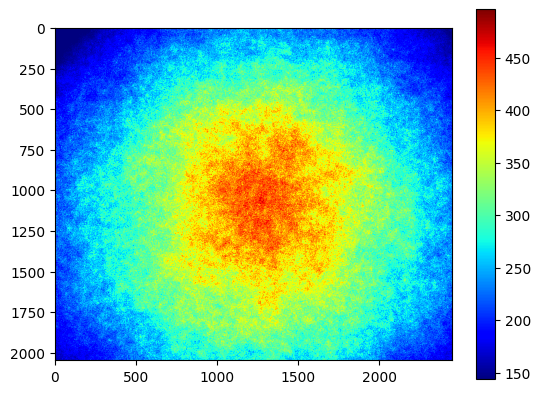

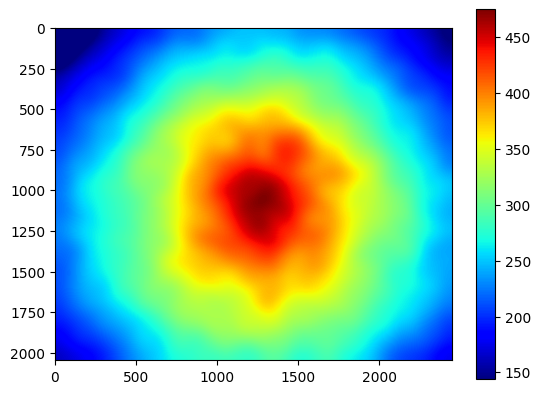

In [79]:
# channel = 'FarRed'
# loc = ''
# n_pos = len(posnames)
# out_img = ''
# n_pixels = 25
# for i,posname in tqdm(enumerate(np.random.choice(posnames,n_pos,replace=False)),total=n_pos):
#     img = image_metadata.stkread(Position=posname,Channel=channel,acq=acq).min(2).astype(np.float32)
#     if channel=='FarRed':
#         bkg = image_metadata.stkread(Position=posname,Channel=channel,acq=bkg_acq).min(2).astype(np.float32)
#         img = img-bkg
#     img = median_filter(img,2)
#     if isinstance(loc,str):
#         loc = {}
#         for r in range(n_pixels):
#             loc[r]= np.random.randint(np.ones([img.shape[0],img.shape[1]])*n_pos)
#         out_stk = np.zeros([img.shape[0],img.shape[1],n_pixels],dtype= np.float32)
#     for r in range(n_pixels):
#         m = loc[r]==i
#         out_stk[m,r] = img[m]
out_img = np.median(out_stk,axis=2)
img = out_img.copy()
vmin,vmax = np.percentile(img.ravel(),[5,95])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()
# img = np.clip(img,vmin,vmax)
# vmin,vmax = np.percentile(img.ravel(),[5,95])
# img = image_filter(out_img.copy(),'downsample_quantile_0.5',50)
img = image_filter(out_img.copy(),'gaussian',50)
# img = image_filter(out_img.copy(),'median',10)
# img = image_filter(out_img.copy(),'rolling_ball',50)
# bottom = restoration.rolling_ball(img.copy(),radius=10,num_threads=30)
# top = -restoration.rolling_ball(-img.copy(),radius=10,num_threads=30)
# img = (bottom+top)/2
# img = restoration.rolling_ball(img.copy(),radius=10,num_threads=30)
# img = image_filter(out_img.copy(),'median',10)
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()

vmin,vmax = np.percentile(img.ravel(),[5,95])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()

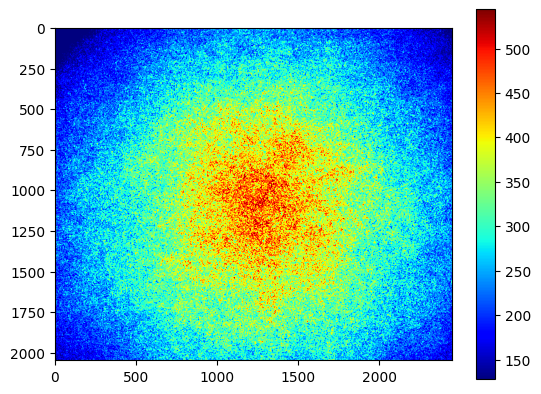

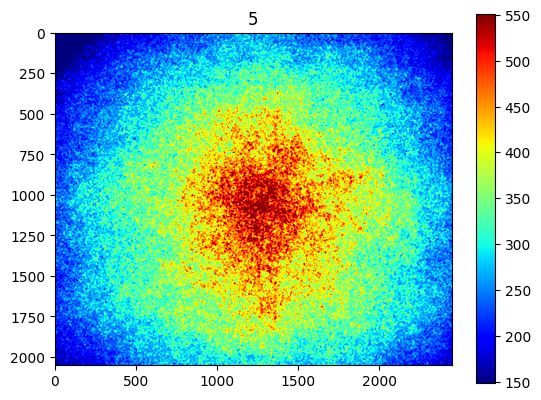

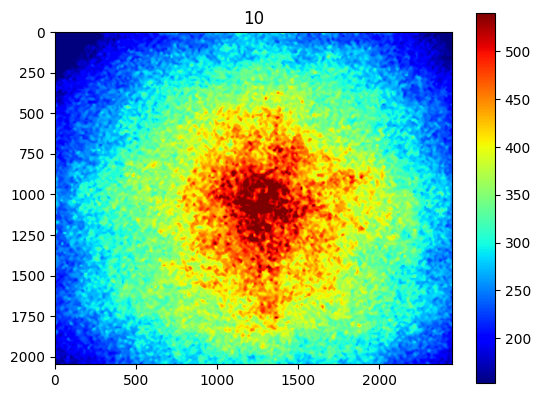

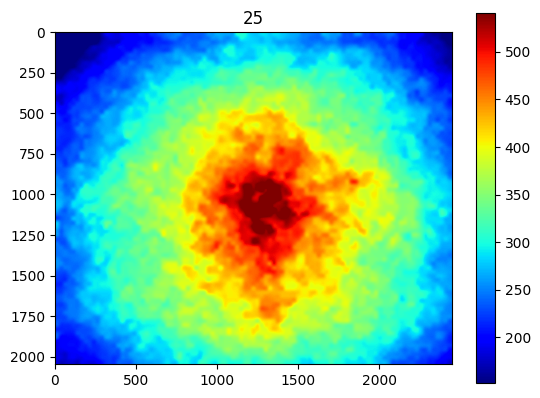

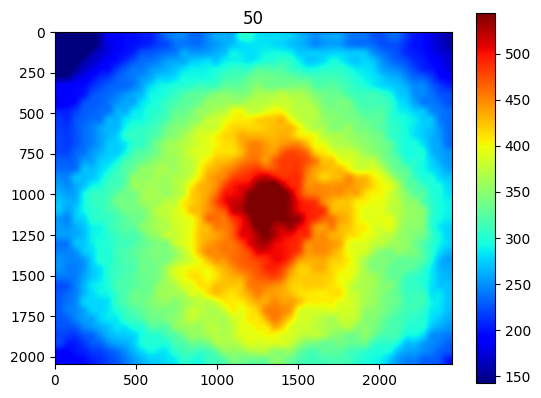

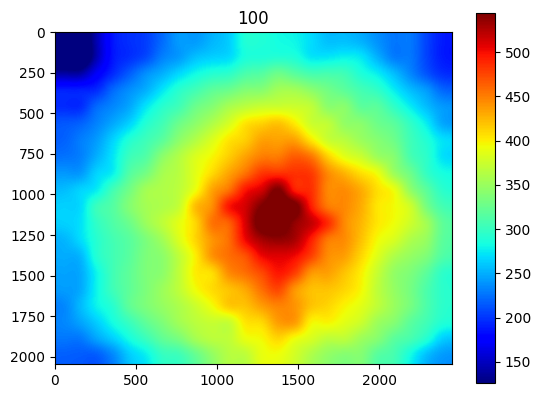

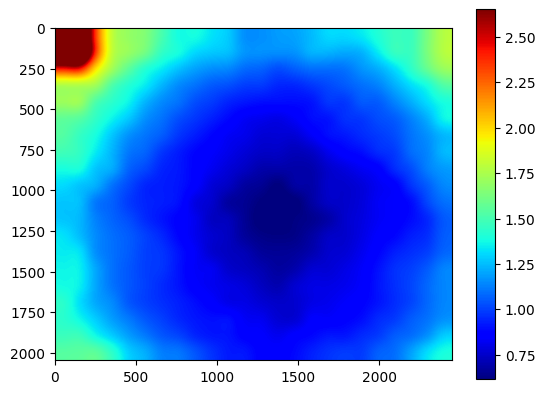

In [43]:
img = out_img.copy()
from dredFISH.Processing.Section import *
img = median_filter(img,5)
vmin,vmax = np.percentile(img.ravel(),[1,99])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()
img = out_img.copy()
for i in reversed([100,50,25,10,5]):
    img = image_filter(img,'downsample_quantile_0.5',i)
    vmin,vmax = np.percentile(img.ravel(),[1,99])
    plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
    plt.title(i)
    plt.colorbar()
    plt.show()

img = np.median(img)/img
vmin,vmax = np.percentile(img.ravel(),[1,99])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
fit_img = np.dstack([rbfi(np.array(range(img.shape[0])),np.ones(img.shape[0])*i) for i in trange(img.shape[1])])
fit_img.shape

In [ ]:
plt.scatter(rbfi(x,y),z,s=0.1)
plt.show()

In [ ]:
import inspect
from tqdm import trange
channel = 'FarRed'
binsize = 50
overlap = 1

pos_idx = 0
# channel = 'DeepBlue'
dtype=np.float32
print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
signal = image_metadata.stkread(Position=posnames[pos_idx],Channel=channel,acq=acq).min(2).astype(dtype)
signal = median_filter(signal,2)
strip = image_metadata.stkread(Position=posnames[pos_idx],Channel=channel,acq=bkg_acq).min(2).astype(dtype)
strip = median_filter(strip,2)

if channel =='DeepBlue':
    img = signal
else:
    img = signal-strip

vmin,vmax = np.percentile(img.ravel(),[5,95])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()
print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
original_width, original_height = img.shape
new_width = int(original_width/binsize)
new_height = int(original_height/binsize)
original_width = new_width*binsize
original_height = new_height*binsize
# Resize to be a multiple of binsize
img = np.array(Image.fromarray(img.astype(float)).resize((original_height,original_width), Image.BICUBIC)).astype(dtype)
img = torch.tensor(img,dtype=torch.float32)

img_down = torch.zeros([new_width*overlap,new_height*overlap],dtype=torch.float32)
print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
for x in trange(img_down.shape[0]):
    for y in range(img_down.shape[1]):
        x_center = int((x*binsize)/overlap)
        y_center = int((y*binsize)/overlap)
        img_down[x,y] = torch.quantile(img[x_center:x_center+binsize,y_center:y_center+binsize],0.05)
print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
img = img_down.numpy().astype(dtype)
img = median_filter(img,2*overlap)
scale = np.array(signal.shape)
img = np.array(Image.fromarray(img.astype(float)).resize((scale[1],scale[0]), Image.BICUBIC))
vmin,vmax = np.percentile(img.ravel(),[5,95])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()

print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
if channel =='DeepBlue':
    img = signal-img
else:
    img = (signal-strip)-img
vmin,vmax = np.percentile(img.ravel(),[5,95])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()
print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))


# binsize = 500
# overlap = 10

# signal = img.copy()

# original_width, original_height = img.shape
# new_width = int(original_width/binsize)
# new_height = int(original_height/binsize)
# original_width = new_width*binsize
# original_height = new_height*binsize
# # Resize to be a multiple of binsize
# img = np.array(Image.fromarray(img.astype(float)).resize((original_height,original_width), Image.BICUBIC)).astype(dtype)
# img = torch.tensor(img,dtype=torch.float32)

# img_down = torch.zeros([new_width*overlap,new_height*overlap],dtype=torch.float32)
# print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
# for x in trange(img_down.shape[0]):
#     for y in range(img_down.shape[1]):
#         x_center = int((x*binsize)/overlap)
#         y_center = int((y*binsize)/overlap)
#         img_down[x,y] = torch.quantile(img[x_center:x_center+binsize,y_center:y_center+binsize],0.5)
# print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
# img = img_down.numpy().astype(dtype)
# img = median_filter(img,2)
# scale = np.array(signal.shape)
# img = np.array(Image.fromarray(img.astype(float)).resize((scale[1],scale[0]), Image.BICUBIC))
# vmin,vmax = np.percentile(img.ravel(),[5,95])
# plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
# plt.colorbar()
# plt.show()
# print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))
# FF = np.median(img.ravel())/img
# img = signal*FF
# vmin,vmax = np.percentile(img.ravel(),[5,95])
# plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
# plt.colorbar()
# plt.show()
# print(inspect.currentframe().f_lineno,str(datetime.now().strftime("%Y %B %d %H:%M:%S")))